## Ignore Warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Import the Dataset

In [3]:
data = pd.read_csv('data/Emotion_final.csv')

In [4]:
data.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Counts of Sentiments

In [5]:
data.Emotion.value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [6]:
data.shape

(21459, 2)

## Encode the Sentiments

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
le = LabelEncoder()

In [9]:
data['Emotion_Le'] = le.fit_transform(data['Emotion'])

In [10]:
data['Emotion_Le']

0        4
1        4
2        0
3        3
4        0
        ..
21454    1
21455    1
21456    1
21457    1
21458    1
Name: Emotion_Le, Length: 21459, dtype: int64

## Import nltk, download 'stopwords' and create the object lemmatizer

In [11]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/mertc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence

In [13]:
corpus = list()
for i in range(data.shape[0]):
    sentence = re.sub('[^a-zA-Z]', ' ', data['Text'][i])
    sentence = sentence.lower() # stringin tüm harflerini küçültür.
    sentence = clean_up_sentence(sentence)
    # 'stem' ile kelimenin kökünü alıyoruz
    corpus.append(sentence)

In [14]:
corpus

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [15]:
# Feature Extraction (Öznitelik Çıkarımı)
from sklearn.feature_extraction.text import CountVectorizer
cVectorizer = CountVectorizer(max_features=2000)
# 'max_features=2000' anlamı, en fazla kullanılan 2000 kelimeyi al, fazlasını alma!!
X = cVectorizer.fit_transform(corpus).toarray() # bağımsız değişken
y = data['Emotion_Le'].values # bağımlı değişken

In [16]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
y

array([4, 4, 0, ..., 1, 1, 1])

## Split the data as train, test and validation

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state=0)

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rnd_clf = RandomForestClassifier().fit(X_train, y_train)

In [21]:
y_pred = rnd_clf.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(y_test, y_pred)

0.8560111835973905

# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
log_clf = LogisticRegression().fit(X_train, y_train)

In [26]:
y_pred = log_clf.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred)

0.8681267474370923

## Hyperparameter Optimization using GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
param_grid = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "dual": [True, False],
    "fit_intercept": [True, False],
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [30]:
log_clf = LogisticRegression()
grid_model = GridSearchCV(log_clf, param_grid, n_jobs=-1, cv=10, verbose=2).fit(X_val, y_val)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  7.8min finished


### Best Parameters

In [31]:
grid_model.best_params_

{'dual': False, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

### Final Model

In [32]:
log_final = LogisticRegression(dual=grid_model.best_params_['dual'], 
                               fit_intercept=grid_model.best_params_['fit_intercept'], 
                               penalty=grid_model.best_params_['penalty'], 
                               solver=grid_model.best_params_['solver']
                              ).fit(X_train, y_train)

In [33]:
y_pred = log_final.predict(X_test)

In [34]:
accuracy_score(y_test, y_pred)

0.8851351351351351

# Deep Learning(Keras)

In [35]:
import keras

In [36]:
X_train.shape

(13733, 2000)

## Create Deep Learning Model

In [37]:
model = keras.models.Sequential()

model.add(keras.Input(shape=(2000, )))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.50))
model.add(keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 128,454
Trainable params: 128,454
Non-trainable params: 0
_________________________________________________________________


### Compiling and training

In [38]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.adamax_v2.Adamax(),
              metrics=['acc'])

In [39]:
epochs=20
history = model.fit(X_train, y_train, batch_size=16, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
859/859 [==============================] - 4s 4ms/step - loss: 1.6004 - acc: 0.3568 - val_loss: 1.5150 - val_acc: 0.4461
Epoch 2/20
859/859 [==============================] - 3s 4ms/step - loss: 1.4695 - acc: 0.4419 - val_loss: 1.4011 - val_acc: 0.5058
Epoch 3/20
859/859 [==============================] - 3s 4ms/step - loss: 1.3388 - acc: 0.5100 - val_loss: 1.2634 - val_acc: 0.5588
Epoch 4/20
859/859 [==============================] - 3s 4ms/step - loss: 1.1929 - acc: 0.5824 - val_loss: 1.1187 - val_acc: 0.6214
Epoch 5/20
859/859 [==============================] - 4s 4ms/step - loss: 1.0472 - acc: 0.6504 - val_loss: 0.9732 - val_acc: 0.6948
Epoch 6/20
859/859 [==============================] - 3s 4ms/step - loss: 0.8972 - acc: 0.7166 - val_loss: 0.8382 - val_acc: 0.7510
Epoch 7/20
859/859 [==============================] - 3s 4ms/step - loss: 0.7813 - acc: 0.7590 - val_loss: 0.7304 - val_acc: 0.7912
Epoch 8/20
859/859 [==============================] - 4s 5ms/step - loss: 0.

### Plot the training

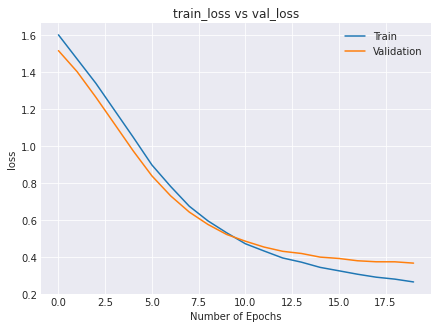

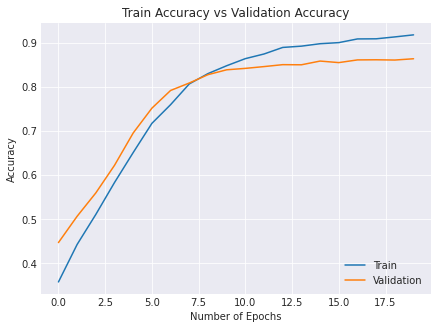

In [40]:
plt.style.use("seaborn-darkgrid")
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
xc = range(epochs)

plt.figure(1, figsize=(7,5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['Train','Validation'])

plt.figure(2, figsize=(7,5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.grid(True)
plt.legend(['Train','Validation'], loc = 4)
plt.style.use("seaborn-darkgrid")

plt.show()

### Results of several metrics

In [41]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, recall_score, cohen_kappa_score, precision_score
import numpy as np

def metric(X_test, y_test, model, model_name:str): 
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    print('{} Model Accuracy Score:  {:.2}'.format(model_name,  accuracy_score(y_test, y_pred)))
    print('\n{} Model Balanced Accuracy Score: {:.2} '.format(model_name, balanced_accuracy_score(y_test, y_pred)))
    print('\n{} Model F1 Score: {:.2} '.format(model_name, f1_score(y_test, y_pred, pos_label='positive', average='micro')))
    print('\n{} Model Precision Score: {:.2} '.format(model_name, precision_score(y_test, y_pred, pos_label='positive', average='micro')))
    print('\n{} Model Cohen Kappa Score: {:.2} '.format(model_name, cohen_kappa_score(y_test, y_pred)))
    print('\n{} Model Recall Score: {:.2} '.format(model_name, recall_score(y_test, y_pred, pos_label='positive', average='micro')))

In [42]:
metric(X_test, y_test, model, model_name="MLPC")

MLPC Model Accuracy Score:  0.87

MLPC Model Balanced Accuracy Score: 0.83 

MLPC Model F1 Score: 0.87 

MLPC Model Precision Score: 0.87 

MLPC Model Cohen Kappa Score: 0.84 

MLPC Model Recall Score: 0.87 


In [43]:
model.evaluate(X_test, y_test)

135/135 [==============================] - 0s 3ms/step - loss: 0.3447 - acc: 0.8749


[0.344655841588974, 0.8748835325241089]

# Deep Learning(PyTorch)

In [44]:
import torch
import torch.nn as nn

### Create Class of Net

In [45]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dense1 = nn.Linear(2000, 64)
        self.dropout = nn.Dropout(0.50)
        self.dense2 = nn.Linear(64, 6)

    def forward(self, x):
        x_1 = torch.relu(self.dense1(x))
        x_2 = self.dropout(x_1)
        x_3 = self.dense2(x_2)
        return x_3

model = Net()

In [46]:
model

Net(
  (dense1): Linear(in_features=2000, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=64, out_features=6, bias=True)
)

### Define the criterion and optimizer

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters())

In [48]:
y_train

array([2, 3, 0, ..., 2, 1, 1])

In [49]:
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
y_train_t = torch.from_numpy(y_train)
y_test_t = torch.from_numpy(y_test)

In [50]:
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_t, y_train_t), batch_size=16)

### Training

In [51]:
for i in range(20):
    for t, data_t in enumerate(trainloader):
        inputs, labels = data_t
        optimizer.zero_grad()
        y_pred = model(inputs.float())
        loss = criterion(y_pred, labels.long())
        loss.backward()
        optimizer.step()

In [52]:
y_pred = model(X_test_t.float())
y_pred = y_pred.detach().numpy()

In [53]:
y_pred = 1 * (y_pred > 0.5)

In [54]:
y_pred = np.argmax(y_pred, axis=1)

### Results

In [55]:
print("Confusion Matrix: \n {}".format(confusion_matrix(y_test, y_pred)))
print("Accuracy: {:.3}".format(accuracy_score(y_test, y_pred)))

Confusion Matrix: 
 [[ 565    5   13    2   15    0]
 [  59  436   11    2   15    3]
 [  71   13 1281   17   14    3]
 [  17    3  129  169    6    1]
 [ 120   45   91    5  997    0]
 [  16   54   19    1    6   88]]
Accuracy: 0.824


***logistic regression gave the best result according to the results, save the model***

In [56]:
import pickle

In [57]:
filename = "log_final_model.sav"
pickle.dump(rnd_clf, open(filename, 'wb'))

In [58]:
loaded_model = pickle.load(open(filename, 'rb'))

In [59]:
result = loaded_model.score(X_test, y_test)

In [60]:
print(result)

0.8560111835973905


### Save the Vectorizer for transforming the text data

In [61]:
filename = "cVectorizer.sav"
pickle.dump(cVectorizer, open(filename, 'wb'))

In [62]:
cVectorizer = pickle.load(open("cVectorizer.sav", 'rb'))

### Match the labels with the numbers and create dictionary

In [63]:
values = data['Emotion'].value_counts()

In [64]:
keys = data['Emotion_Le'].value_counts()

In [65]:
keys

2    7029
4    6265
0    2993
1    2652
3    1641
5     879
Name: Emotion_Le, dtype: int64

In [66]:
values

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [67]:
keys.index.tolist()

[2, 4, 0, 1, 3, 5]

In [68]:
values.index.tolist()

['happy', 'sadness', 'anger', 'fear', 'love', 'surprise']

In [69]:
dict_sentiment = dict(zip(keys.index.tolist(), values.index.tolist()))

In [70]:
dict_sentiment

{2: 'happy', 4: 'sadness', 0: 'anger', 1: 'fear', 3: 'love', 5: 'surprise'}

In [71]:
import pickle

In [72]:
filename = "dictionary.sav"
pickle.dump(dict_sentiment, open(filename, 'wb'))

In [73]:
dict_sentiment.get(1)

'fear'